| **Chapter**                   | 3:  Host factors              |
| ----------------------------- |-------------------------------|
| **Computational Note**        | 3.x: Contact matrix inference |
| **Package prerequisites**     | None                          |



# Contact matrix inference

In this notebook, we will be creating synthetic contact matrices using a simplified version of the method described in Mistry _et al_. (2021).[^1] We will create the household, school and work matrices, then combine them into a composite matrix that is a linear combination of the household, school and work matrices.

We will be using data from the US Census, obtained from IPUMS.[^2] Data on schools in Virginia were obtained from the Fall Membership published by the Virginia Department of Education.[^3] Data on teacher demographics come from `EEOALL1R` of the American Community Survey.[^4] Data on employer sizes in Virginia comes from `CB2000CBP`.[^5]

## General matrix construction

The encounter matrices are asymmetric matrices of per capita age specific encounter likelihoods. The value $M_{i,j}$ is given by dividing the number of non-self encounters between ages $i$ and $j$ by the abundance of $i$ and $j$, respectively, within the setting (the household, school, etc.). This figure is then divided by the number of individuals in the entire model of age $i$, as we want to per-capitalise this model. The first matrix is symmetric, the second matrix is of course not necessarily so.

## The composite matrix

The composite matrix is a linear combination of $\eta_H \mathbf{H} + \eta_S \mathbf{S} + \eta_W \mathbf{W}$. We will be using the Mistry _et al._ (2021) multipliers,[^1] with the difference that since we do not construct a social encounter matrix, we add the social multiplier to the household multiplier. Given reference data, such as POLYMOD, we can fit these parameters to approximate the reference data better.

## Data access

Licensing restrictions do not permit reproduction of the data. However, they can be obtained free of charge from the website of the [United States Census Bureau](https://data.census.gov), [IPUMS](https://us.ipums.org) (requires free registration) and the [Virginia Department of Education](https://www.doe.virginia.gov/statistics_reports/enrollment/index.shtml). The query parameters required to obtain the data sets are below.


### Household data (`usa_00004.csv`)

Obtained from [IPUMS](https://us.ipums.org).[^2]

* Sample: 2019 ACS
* Variables: `SERIAL`, `STATEFIP` `PERNUM`, `FAMSIZE`, `RELATE`, `RELATED`, `AGE`
* Case selection:
    - `STATEFIP = 51 Virginia`


### Fall Membership Report (`fall_membership_statistics.csv`)

Obtained from the [Virginia DOE](https://www.doe.virginia.gov/statistics_reports/enrollment/index.shtml)'s Fall Membership Build-A-Table, for

* School year: `2021-2022`
* Report level: `School`.


### Teacher age data (`usa_00005.csv`)

Obtained from [IPUMS](https://us.ipums.org).[^2]

* Sample: 2019 ACS
* Variables: `SERIAL`, `STATEFIP`, `PERNUM`, `AGE`, `EMPSTAT`, `EMPSTATD`, `OCC2010`
* Case selection:
    - `STATEFIP = 51 Virginia`
    - `EMPSTAT = 1 Employed`,
    - `OCC2010` is one of `2300`, `2310`, `2320`, `2330`

### `EEOALL1R` data for absolute number of teachers

Obtained from the [US Census Bureau](https://data.census.gov/cedsci/table?q=EEOALL1R&tid=ACSEEO5Y2018.EEOALL1R).[^5]

* Geos: `State = Virginia`
* Codes: EEO occupation code is one of `2300`, `2310`, `2320`, `2330`

### Employee data (`usa_00006.csv`)

Obtained from [IPUMS](https://us.ipums.org).[^2]

* Sample: 2019 ACS
* Variables: `SERIAL`, `STATEFIP`, `PERNUM`, `AGE`, `EMPSTAT`, `EMPSTATD`, `OCC2010`
* Case selection:
    - `STATEFIP = 51 Virginia`
    - `OCC2010` is not one of `2300`, `2310`, `2320`, `2330`


### `CB2000CBP` data on enterprise sizes[^5]

Obtained from the [US Census Bureau](https://data.census.gov/cedsci/table?q=CB2000CBP%3A%20All%20Sectors%3A%20County%20Business%20Patterns,%20including%20ZIP%20Code%20Business%20Patterns,%20by%20Legal%20Form%20of%20Organization%20and%20Employment%20Size%20Class%20for%20the%20U.S.,%20States,%20and%20Selected%20Geographies%3A%202020&tid=CBP2020.CB2000CBP).

* Geos: `State = Virginia`
* Years: `2020`

### Comparator matrix from Mistry _et al._ (2021)[^1]

Obtained from the [Github repository](https://github.com/mobs-lab/mixing-patterns).


[^1]: Mistry, D., Litvinova, M., Pastore y Piontti, A. et al. Inferring high-resolution human mixing patterns for disease modeling. Nat Commun 12, 323 (2021). [link](https://doi.org/10.1038/s41467-020-20544-y)
[^2]: Steven Ruggles, Sarah Flood, Ronald Goeken, Megan Schouweiler and Matthew Sobek. IPUMS USA: Version 12.0 [dataset]. Minneapolis, MN: IPUMS, 2022. [link](https://doi.org/10.18128/D010.V12.0)
[^3]: Virginia Department of Education. Fall Membership Reports, 2021-22. [link](https://www.doe.virginia.gov/statistics_reports/enrollment/index.shtml)
[^4]: United States Census Bureau. `EEOALL1R`: EEO 1-Year Detailed Census Occupation by Sex and Race/Ethnicity for Residence Geography, 2018, 5-year estimates. [link](https://data.census.gov/cedsci/table?q=EEOALL1R&tid=ACSEEO5Y2018.EEOALL1R)
[^5]: United States Census Bureau. `CB2000CBP`: All Sectors: County Business Patterns. 2020. [link](https://data.census.gov/cedsci/table?q=CB2000CBP%3A%20All%20Sectors%3A%20County%20Business%20Patterns,%20including%20ZIP%20Code%20Business%20Patterns,%20by%20Legal%20Form%20of%20Organization%20and%20Employment%20Size%20Class%20for%20the%20U.S.,%20States,%20and%20Selected%20Geographies%3A%202020&tid=CBP2020.CB2000CBP)


In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import random
import itertools
from scipy.optimize import minimize
from typing import Iterable
import colorcet as cc
from collections import Counter, defaultdict
import scipy.sparse as sp
from tqdm.notebook import trange, tqdm
import seaborn as sns

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

# Generating the synthetic households

Households are generated according to the following algorithm:

* Set a tolerance $\epsilon$. A good starting value for $\epsilon$ is 2, meaning that age-matched samples will include a two-year band either side of the specified value.
* Determine the household size, drawn from the distribution of household sizes. The household sizes are calculated by taking the `FAMSIZE` property when grouping by unique household IDs (`SERIAL`).
* Determine the head of household's (HOH) age by drawing from the ages of heads of household who have the given household size.
* If the household size > 1, filter all heads of household of the HOH's age $\pm \epsilon$, and draw a random selection from their spouse's age. This will return a `NaN` exactly at the ratio at which this cohort would not have a spouse, otherwise the spouse's age. Thus, it selects both for the spouse's existence and her age. If a spouse is added, decrement the number of individuals to be allocated.
* While there are individuals left to be allocated,
    - determine whether to allocate a child or an 'other' (e.g. parent, sibling, etc.) by $rand() \stackrel{?}{>} \frac{N_{\text{children}}}{N_{\text{children}} + N_{\text{others}}}$ given the HOH's age,
    - if allocating a child,
       + if there is a spouse, select from the set of children in families where the spouse's age and the HOH's age are $\pm \epsilon$ those of the simulated HOH and spouse's ages,
       + if there is no spouse, select from the set of children in families based on the HOH's age,
    - if allocating an other relative, do the same _mutatis mutandis_.

In [2]:
household_df = pd.read_csv("usa_00004.csv")

In [3]:
family_size_distribution = household_df.groupby("SERIAL")["FAMSIZE"].first().to_list()

In [4]:
# Filtering out non-relatives, institutional settings etc.

household_df = household_df[household_df.RELATE <= 10]

In [5]:
heads_of_household = household_df[household_df.RELATE == 1]
spouses = household_df[household_df.RELATE == 2]
children = household_df[household_df.RELATE == 3]
others = household_df[~household_df.RELATE.isin([1, 2, 3])]

In [6]:
# Appending spousal age to HoHs to infer

heads_of_household = heads_of_household.merge(spouses[["AGE", "SERIAL"]], on="SERIAL", how="left", suffixes=("", "_spouse"))

In [7]:
# Data frame for children as a function of their parents' ages

age_children = children.merge(heads_of_household[["AGE", "SERIAL"]], on="SERIAL", how="left", suffixes=("", "_hhp")).merge(spouses[["AGE", "SERIAL"]], on="SERIAL", how="left", suffixes=("", "_spp"))

In [8]:
age_others = others.merge(heads_of_household[["AGE", "SERIAL"]], on="SERIAL", how="left", suffixes=("", "_hhp")).merge(spouses[["AGE", "SERIAL"]], on="SERIAL", how="left", suffixes=("", "_spp"))

In [9]:
# Data frame for the number of children as a function of their parents' ages

heads_of_household = children.groupby("SERIAL").count()["CBSERIAL"].reset_index().rename(columns={"CBSERIAL": "count_children"}).merge(heads_of_household, on="SERIAL", how="right")

In [10]:
heads_of_household = others.groupby("SERIAL").count()["CBSERIAL"].reset_index().rename(columns={"CBSERIAL": "count_others"}).merge(heads_of_household, on="SERIAL", how="right")

In [11]:
def generate_household(tolerance=2):
    household_size = random.choice(family_size_distribution)
    
    hoh_age = heads_of_household[heads_of_household.FAMSIZE == household_size].AGE.sample(1).values[0]
    
    relations_ages = []
    
    if household_size > 1:
        remaining_to_allocate = household_size - 1

        hoh_age_cohort = heads_of_household[heads_of_household.AGE.between(hoh_age - tolerance,
                                                                           hoh_age + tolerance)]
        
        spouse_age = hoh_age_cohort["AGE_spouse"].sample(1).values[0]
        if not np.isnan(spouse_age):
            relations_ages.append(spouse_age)
            remaining_to_allocate -= 1
            
        if remaining_to_allocate:
            children_others_ratio = hoh_age_cohort.count_children.count()/(
                hoh_age_cohort.count_children.count() + hoh_age_cohort.count_others.count()
            )
            
            if not np.isnan(spouse_age):
                # if spouse, then the child's age is determined by both parents' ages
                allocatable_children = age_children[(age_children.AGE_hhp.between(hoh_age - tolerance,
                                                                                 hoh_age + tolerance)) & 
                                                    (age_children.AGE_spp.between(spouse_age - tolerance,
                                                                                  spouse_age + tolerance))]
                allocatable_others = age_others[(age_others.AGE_hhp.between(hoh_age - tolerance,
                                                                                 hoh_age + tolerance)) & 
                                                    (age_others.AGE_spp.between(spouse_age - tolerance,
                                                                                  spouse_age + tolerance))]
            
            else:
                allocatable_children = age_children[age_children.AGE_hhp.between(hoh_age - tolerance,
                                                                                 hoh_age + tolerance)]
                allocatable_others = age_others[age_others.AGE_hhp.between(hoh_age - tolerance,
                                                                                 hoh_age + tolerance)]

                
            while remaining_to_allocate:
                if (np.random.rand() < children_others_ratio or len(allocatable_others) == 0) and len(allocatable_children) > 0:
                    # allocate a child
                    relations_ages.append(allocatable_children.sample(1).AGE.values[0])
                else:
                    if len(allocatable_others) > 0:
                        relations_ages.append(allocatable_others.sample(1).AGE.values[0])
                
                remaining_to_allocate -= 1
        
    return list(map(int, [hoh_age, *relations_ages]))

In [12]:
def generate_households(n=500, max_age:int=100, *args, **kwargs) -> np.array:
    household_cooccurrence_matrix = np.zeros((max_age, max_age))
    population_matrix = np.zeros((max_age))

    for i in trange(n):
        synthetic_household = generate_household(*args, **kwargs)
        for iidx, ival in enumerate(synthetic_household):
            population_matrix[ival] += 1
            for jidx, jval in enumerate(synthetic_household):
                if iidx != jidx:
                    ival = min(ival, max_age)
                    jval = min(jval, max_age)
                    household_cooccurrence_matrix[ival][jval] += 1/(len(synthetic_household) - 1)
                    household_cooccurrence_matrix[jval][ival] += 1/(len(synthetic_household) - 1)

    with np.errstate(divide="ignore", invalid="ignore"):
        result = np.true_divide(household_cooccurrence_matrix, population_matrix.reshape(len(population_matrix), 1))
        result[result == np.inf] = 0
        result = np.nan_to_num(result)

    return result

In [13]:
# Reference value:
# Number of households in VA: 3_184_000

households_cm = generate_households(3_184_000)

  0%|          | 0/3184000 [00:00<?, ?it/s]

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_50575/2210083524.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("linear_bmy_10_95_c71").copy()
  cmap.set_bad(cmap(1e-4), 1)


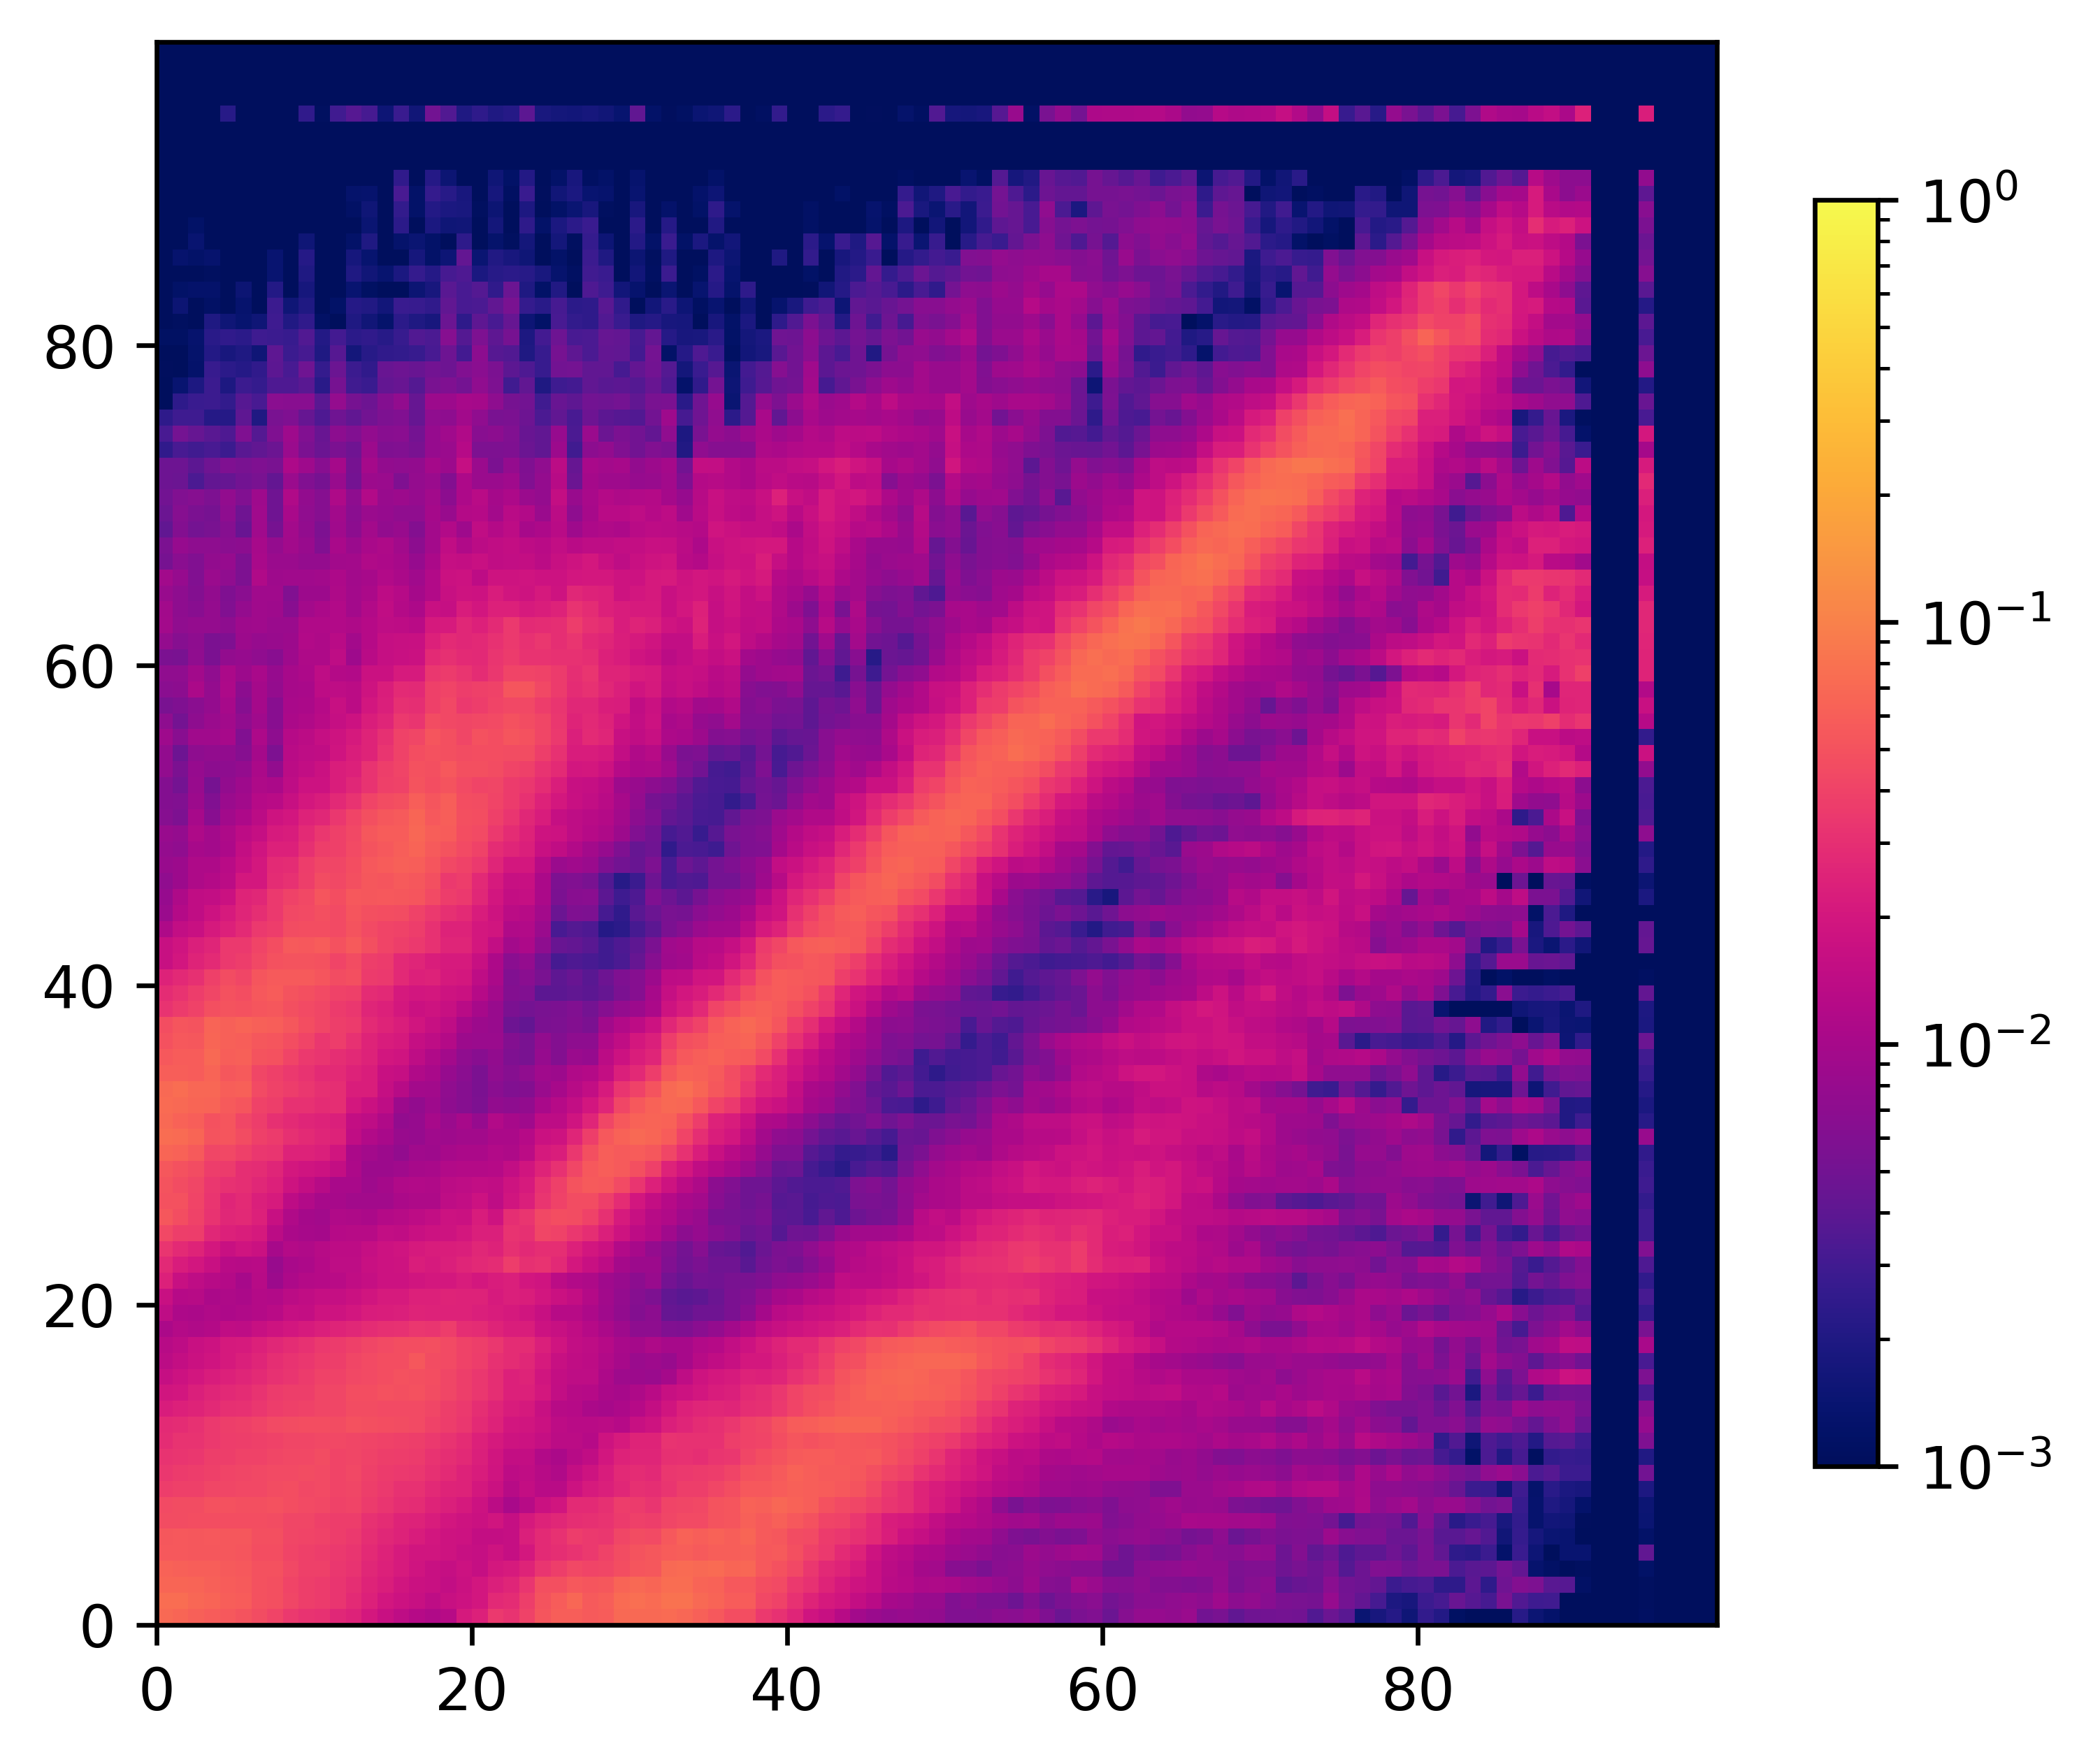

In [14]:
fig = plt.figure(figsize=(6, 5), dpi=600)
ax = fig.add_subplot(111)

cmap = cc.cm.CET_L8
cmap.set_bad(cmap(1e-4), 1)

pcm = plt.pcolormesh(np.ma.masked_where(households_cm.T == 0, households_cm.T),
                        cmap=cc.cm.CET_L8,
                        norm=LogNorm(vmin=1e-3, vmax=1),
                        rasterized=True)

plt.colorbar(shrink=0.8)
plt.ylim(0, 99)
plt.xlim(0, 99)
plt.savefig("household_matrix_va.pdf")

# Generating the synthetic schools

Our base for school statistics is the Fall Membership data set, obtained from the [Virginia Department of Education](https://www.doe.virginia.gov/statistics_reports/enrollment/index.shtml).

A synthetic school consists of a student body and a faculty.

* First, we determine the student-to-faculty ratios based on allocating the four classes of teachers (pre-K and kindergarten, primary and middle school, secondary school, special education).
* Next, we create distributions for the students whose grade does not deterministically yield their age: KG and pre-K students. For anyone else, $\text{age} = g + 6$.

In [15]:
fall_membership = pd.read_csv("fall_membership_statistics.csv")\
                      .iloc[:, 5:19]\
                      .replace(" ", 0)\
                      .applymap(lambda x: int(x.replace(",", "")) if type(x) is str else 0)

Teacher demographics:
All in VA with EMPSTAT=1 (currently employed) whose OCC2010 code is:
* 2300 Preschool and Kindergarten Teachers
* 2310 Elementary and Middle School Teachers
* 2320 Secondary School Teachers
* 2330 Special Education Teachers

In [16]:
teacher_demographics = pd.read_csv("usa_00005.csv")

# We turn this into lists of ages that is faster to select.

ages_2300 = teacher_demographics[teacher_demographics.OCC2010 == 2300].AGE.to_list()
ages_2310 = teacher_demographics[teacher_demographics.OCC2010 == 2310].AGE.to_list()
ages_2320 = teacher_demographics[teacher_demographics.OCC2010 == 2320].AGE.to_list()
ages_2330 = teacher_demographics[teacher_demographics.OCC2010 == 2330].AGE.to_list()

# Manually garbage-collect teacher_demographics as we won't need it anymore.
del teacher_demographics

The number of teachers is determined as follows:
* EEOALL1R gives us the total number for the sets above (2018, ACS 5-year):
  - 2300 Preschool and Kindergarten Teachers: 19,735
  - 2310 Elementary and Middle School Teachers: 111,710
  - 2320 Secondary School Teachers: 19,575
  - 2330 Special Education Teachers: 7,040
* Teachers are allocated as follows:
  - 2300 series teachers are allocated proportionally as per sum of pre-K and KG population
  - 2310 series teachers are allocated proportionally as per sum of grades 1 to 8 inclusive
  - 2320 series teachers are allocated proportionally as per sum of grades 9 to 12 inclusive
  - SEN teachers are allocated proportionally across grades 1 to 12


In [17]:
# Calculate the student-teacher ratios according to the above
total_2300s = 19_375
total_2310s = 111_710
total_2320s = 19_575
total_2330s = 7_040

STR_2300s = fall_membership.iloc[:, 0:2].sum().sum()/total_2300s
STR_2310s = fall_membership.iloc[:, 2:10].sum().sum()/total_2310s
STR_2320s = fall_membership.iloc[:, 10:14].sum().sum()/total_2320s
STR_2330s = fall_membership.iloc[:, 2:14].sum().sum()/total_2330s

The ages of most schoolchildren are deterministically calculated as $g+6$, where $g$ is the current grade. However, since Pre-K and KG span multiple years, we have to sample the population. To speed this up, we preselect these age ranges and turn them into lists, which are somewhat more efficiently sampled than a Pandas DataFrame.

In [18]:
pk_aged_population = household_df[household_df.AGE.between(3, 6)].AGE.to_list()
kg_aged_population = household_df[household_df.AGE.between(4, 6)].AGE.to_list()

Now, we synthesise a school based on a randomly selected prototype row from the Fall Membership table.

* The student body is determined by taking the respective number of students of a particular age, and appending them to the population.
* Faculty is determined by floor dividing each of the referent student cohort sizes (e.g. pre-K and KG, middle, etc.) by their corresponding student-teacher ratio.

In [19]:
def process_row(row: list,
                cooccurrence_matrix: np.array,
                population_matrix: np.array,
                max_age:int=80) -> list:
    """Processes a Fall Membership row into a synthetic school."""

    synthetic_school_population = []

    # Pre-K sample
    if row[0]:
        synthetic_school_population.append(random.choices(pk_aged_population, k=int(row[0])))

    # KG sample
    if row[1]:
        synthetic_school_population.append(random.choices(kg_aged_population, k=int(row[1])))

    for grade, count in enumerate(row[1:]):
        if grade:
            synthetic_school_population.append(np.repeat(grade + 6, count))

    teachers_2300 = (sum(row[0:2])//STR_2300s).astype("int")
    teachers_2310 = (sum(row[2:10])//STR_2310s).astype("int")
    teachers_2320 = (sum(row[10:14])//STR_2320s).astype("int")
    teachers_2330 = (sum(row[2:14])//STR_2330s).astype("int")

    teachers = random.choices(ages_2300, k=teachers_2300) \
                + random.choices(ages_2310, k=teachers_2310) \
                + random.choices(ages_2320, k=teachers_2320) \
                + random.choices(ages_2330, k=teachers_2330)

    synthetic_school_population.append(teachers)

    # We flatten the array
    synthetic_school_population = list(itertools.chain(*synthetic_school_population))

    for iidx, ival in enumerate(synthetic_school_population):
        population_matrix[ival] += 1
        for jidx, jval in enumerate(synthetic_school_population):
            if iidx != jidx:
                ival = min(ival, max_age)
                jval = min(jval, max_age)
                cooccurrence_matrix[ival][jval] += 1/(len(synthetic_school_population) - 1)
                cooccurrence_matrix[jval][ival] += 1/(len(synthetic_school_population) - 1)

    return cooccurrence_matrix, population_matrix

In [20]:
def generate_synthetic_school_matrix(fraction:float=0.2, max_age=100):
    school_cooccurrence_matrix = np.zeros((max_age, max_age))
    population_matrix = np.zeros((max_age))

    school_subsamples = fall_membership.sample(frac=fraction)

    with tqdm(total=school_subsamples.shape[0]) as pb:
        for idx, row in school_subsamples.iterrows():
            school_cooccurrence_matrix, population_matrix = process_row(row,
                                                                        school_cooccurrence_matrix,
                                                                        population_matrix,
                                                                        max_age)
            pb.update(1)

    with np.errstate(divide="ignore", invalid="ignore"):
        # We divide by
        # - sum(population_matrix) - 1, i.e. the whole population, to obtain the relative abundance of contacts.
        # population_matrix, to per-capitalise this.
        result = np.true_divide(school_cooccurrence_matrix, population_matrix.reshape(len(population_matrix), 1))
        result[result == np.inf] = 0
        result = np.nan_to_num(result)

    return result

In [21]:
schools_cm = generate_synthetic_school_matrix(fraction=1.0)

  0%|          | 0/1862 [00:00<?, ?it/s]

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_50575/1310939375.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("linear_bmy_10_95_c71").copy()
  cmap.set_bad(cmap(1e-7), 1)


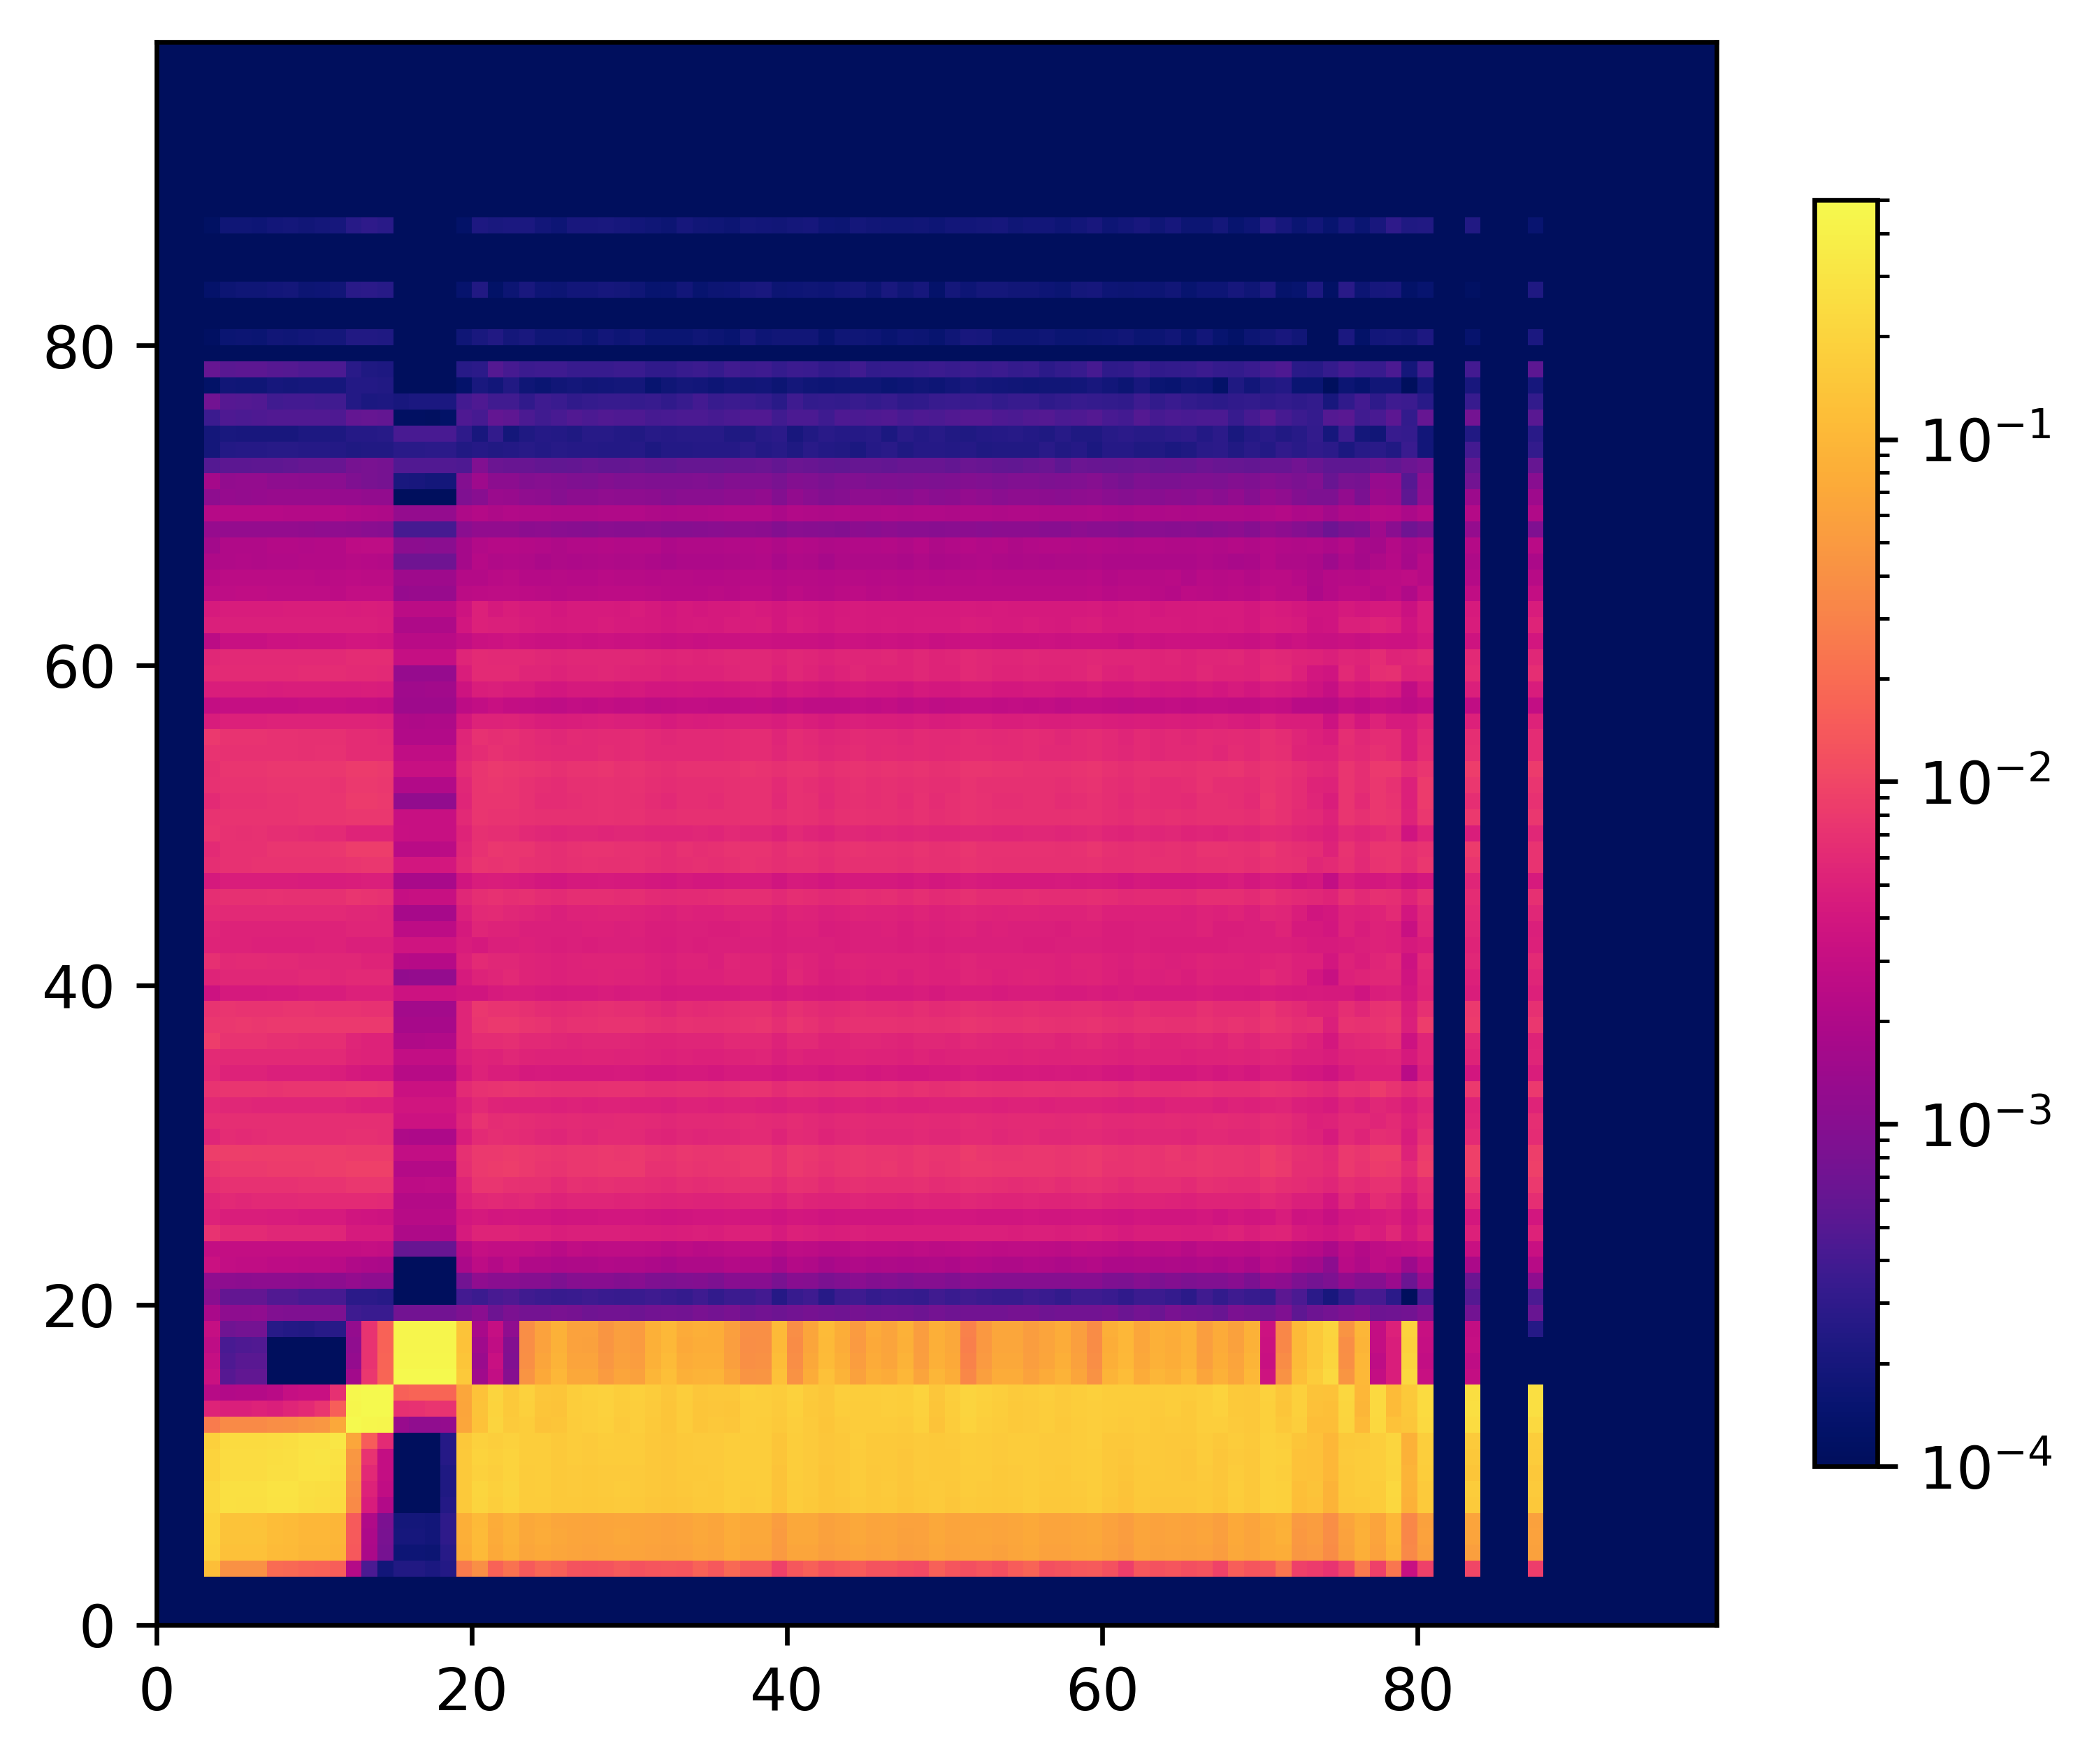

In [22]:
fig = plt.figure(figsize=(6, 5), dpi=600)
ax = fig.add_subplot(111)

cmap = cc.cm.CET_L8
cmap.set_bad(cmap(1e-7), 1)

pcm = plt.pcolormesh(np.ma.masked_where(schools_cm.T == 0, schools_cm.T),
                     cmap=cc.cm.CET_L8,
                     norm=LogNorm(vmin=1e-4, vmax=0.5),
                     rasterized=True)

plt.colorbar(shrink=0.8)
plt.ylim(0, 99)
plt.xlim(0, 99)
plt.savefig("school_matrix_va.pdf")

#Note the asymmetry here: the likelihood of a 40-year-old (i.e. a teacher) to meet a student is very high. On the other hand, the likelihood of a student to meet a 40-year old is much lower - teachers are relatively few compared to students.

# Create synthetic workplaces

First, we ascertain the total employed population who are employed as anything other than a teacher (whom we have of course already taken into account, using the microdata in `usa_00006.csv`: all samples from Virginia whose OCC2021 is not 2300, 2310, 2320 or 2330. This has been already filtered out art the IPUMS query stage.
We will sample the age values of this distribution to attach ages to employees.

CB2000CBP for VA provides the following breakdown of establishment sizes:

| Size      | Number      | Total employees |
|-----------|-------------|-----------------|
| < 5       | 108,240     | 181,820         |
| 5-9       | 36,288      | 241,082         |
| 10-19     | 26,729      | 363,363         |
| 20-49     | 20,792      | 628,883         |
| 50-99     | 6,756       | 462,715         |
| 100-249   | 3,718       | 555,474         |
| 250-499   | 1,030       | 351,757         |
| 500-999   | 368         | 250,032         |
| 1000 <    | 210         | 448,741         |
| **Total** | **204,131** | **3,483,867**   |

We simulate a fraction of businesses $s$ as follows:

* We determine the business size by determining a random size within the size range.
* We assign a sample of employed individuals of the estimated size, and then use the method that ought by now be familiar to create a synthetic matrix.

In [23]:
enterprise_selection_weights = (108_240,
                                36_288,
                                26_729,
                                20_792,
                                6_756,
                                3_718,
                                1_030,
                                368,
                                210)

def synthesise_enterprises(n: int, weights=enterprise_selection_weights) -> list:
    """Synthesises a list of enterprise sizes."""

    enterprise_sizes = [(1, 5),
                        (5, 10),
                        (10, 20),
                        (20, 50),
                        (50, 100),
                        (100, 250),
                        (250, 500),
                        (500, 1_000),
                        (1_000, 5_000)]

    return [random.randrange(*size) for size in random.choices(population=enterprise_sizes,
                                                               weights=weights,
                                                               k=n)]

In [24]:
workers = pd.read_csv("usa_00006.csv")
workers = workers[workers.EMPSTATD == 10]

In [25]:
workers_ages = list(filter(lambda x: x >= 16, workers.AGE.to_list()))

In [26]:
def create_synthetic_workplace(size):
    return random.samples(workers_ages, k=size)

In [27]:
def generate_synthetic_workplace_matrix(fraction:float=0.2, max_age=100) -> np.array:
    workplace_cooccurrence_matrix = np.zeros((max_age, max_age))
    population_matrix = np.zeros((max_age))

    assert fraction <= 1.0

    workplace_sizes = synthesise_enterprises(np.ceil(fraction * np.sum(enterprise_selection_weights)).astype("int"))

    with tqdm(total=len(workplace_sizes)) as pb:
        for i in workplace_sizes:
            workplace_population = random.choices(population=workers_ages, k=i)

            for iidx, ival in enumerate(workplace_population):
                population_matrix[ival] += 1
                for jidx, jval in enumerate(workplace_population):
                    if iidx != jidx:
                        ival = min(ival, max_age)
                        jval = min(jval, max_age)
                        workplace_cooccurrence_matrix[ival][jval] += 1/(len(workplace_population) - 1)
                        workplace_cooccurrence_matrix[jval][ival] += 1/(len(workplace_population) - 1)

            pb.update(1)

    with np.errstate(divide="ignore", invalid="ignore"):
        result = np.true_divide(workplace_cooccurrence_matrix, population_matrix.reshape(len(population_matrix), 1))
        result[result == np.inf] = 0
        result = np.nan_to_num(result)

    return result

In [28]:
workplaces_cm = generate_synthetic_workplace_matrix(fraction=1)

  0%|          | 0/204131 [00:00<?, ?it/s]

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_50575/2822257129.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("linear_bmy_10_95_c71").copy()
  cmap.set_bad(cmap(1e-7), 1)


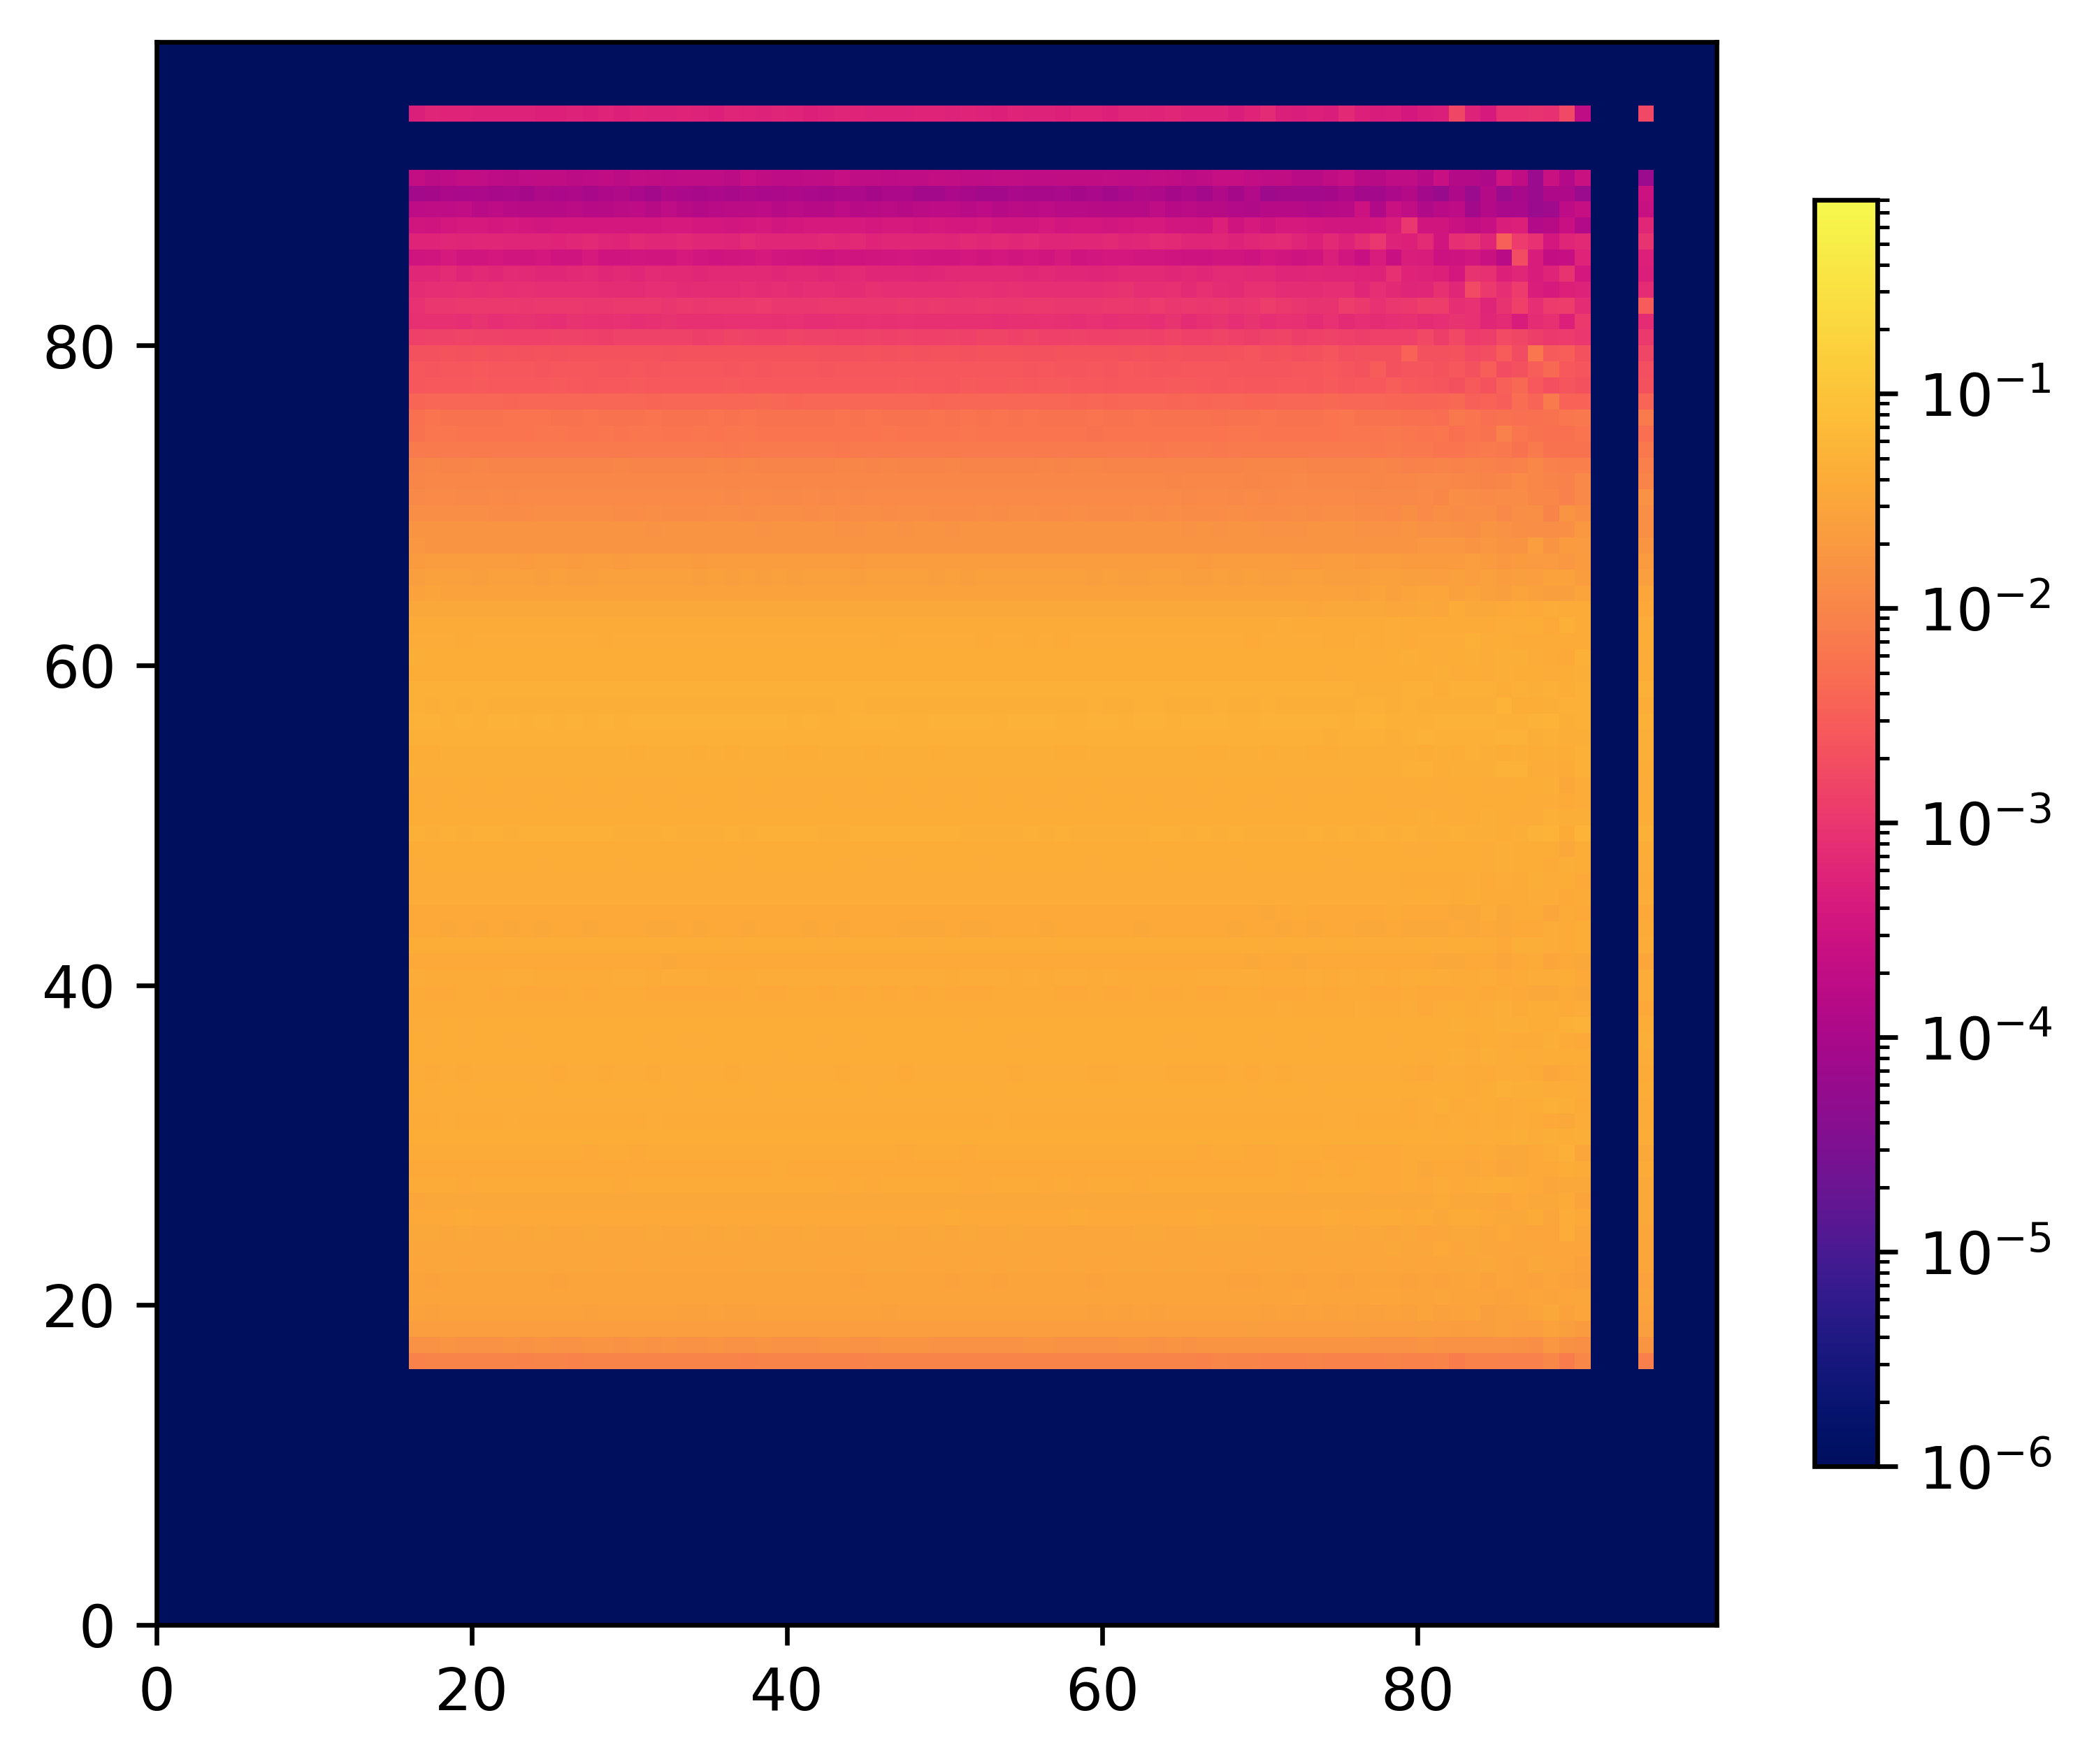

In [29]:
fig = plt.figure(figsize=(6, 5), dpi=600)
ax = fig.add_subplot(111)

cmap = cc.cm.CET_L8
cmap.set_bad(cmap(1e-7), 1)

pcm = plt.pcolormesh(np.ma.masked_where(workplaces_cm.T == 0, workplaces_cm.T),
                     cmap=cc.cm.CET_L8,
                     norm=LogNorm(vmin=1e-6, vmax=0.8),
                     rasterized=True)

plt.colorbar(shrink=0.8)
plt.ylim(0, 99)
plt.xlim(0, 99)
plt.savefig("workplace_matrix_va.pdf")

# Creating the composite matrix

In [30]:
def generate_linear_combination(household_matrix: np.array,
                                school_matrix: np.array,
                                workplace_matrix: np.array,
                                multiplier: np.array) -> np.array:
    """Generates a linear combination, where the last parameter is the linear factor eta."""

    return (multiplier[0] * household_matrix \
                + multiplier[1] * school_matrix \
                + multiplier[2] * workplace_matrix) / sum(multiplier)

In [31]:
def canberra_distance(mat1: np.ndarray, mat2: np.ndarray) -> float:
    if mat1.shape != mat2.shape:
        minx, miny = min(mat1.shape[0], mat2.shape[0]), min(mat1.shape[1], mat2.shape[1])

        mat1 = mat1[:minx, :miny]
        mat2 = mat2[:minx, :miny]

    return np.abs(mat1 - mat2)/(np.abs(mat1) + np.abs(mat2))

In [32]:
def optimising_multipliers(household_matrix: np.array,
                           school_matrix: np.array,
                           workplace_matrix: np.array,
                           comparator_matrix: np.array):
    """Determine optimum linear combination of household, school and workplace matrices against the comparator matrix."""

    def compare_canberra_to_comparator(x: np.array):
        # Returns Canberra distance against the comparator matrix given the 3-length NumPy array of linear coefficients x.

        return np.sum(
            canberra_distance(
                generate_linear_combination(household_matrix,
                                            school_matrix,
                                            workplace_matrix,
                                            multiplier=x), comparator_matrix))

    res = scipy.optimize.minimize(compare_canberra_to_comparator,
                                  # x0 are Mistry et al.'s initial guesses
                                  x0=(6.90, # household: 4.11 + 2.79 for community interactions
                                      11.41, # school interactions,
                                      8.07), # work interactions
                                  method="Nelder-Mead")
    return res.x

In [33]:
mistry_matrix = pd.read_csv("https://raw.githubusercontent.com/mobs-lab/mixing-patterns/main/data/contact_matrices/United_States_subnational_Virginia_M_overall_contact_matrix_85.csv").to_numpy()

In [34]:
optimised_linear_coefficients = optimising_multipliers(households_cm, schools_cm, workplaces_cm, mistry_matrix)

In [35]:
def plot_matrix(mat, ax, cmap=cc.cm.CET_L8, vmin=1e-6, vmax=0.8, **kwargs):
    if "bad_cmap" in kwargs.keys():
        cmap.set_bad(cmap(kwargs["bad_cmap"]), 1)
    else:
        cmap.set_bad(cmap(vmin), 1)

    pcm = ax.pcolormesh(np.ma.masked_where(mat.T == 0, mat.T)[:80, :80],
                         cmap=cmap,
                         norm=LogNorm(vmin=vmin, vmax=vmax),
                         rasterized=True)

In [36]:
def plot_linear_combination(household_matrix: np.array,
                            school_matrix: np.array,
                            workplace_matrix: np.array,
                            comparator_matrix: np.array,
                            multiplier: np.array,
                            figure_name = "linear_combination.pdf",
                            vmins: Iterable = (1e-7, 1e-7, 1e-7, 1e-7),
                            vmaxes: Iterable = (1, 1, 1, 1),
                            cmap=cc.cm.CET_L8,
                            *args, **kwargs):
    """Plots a 3+1 linear combination."""

    final_matrix = generate_linear_combination(household_matrix, school_matrix, workplace_matrix, multiplier)

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(5, 6), sharex=True, sharey=True)

    household, school = axs[0, :]
    work, total = axs[1, :]
    comparator, comparison = axs[2, :]

    print(final_matrix.shape)
    print(comparator_matrix.shape)

    plot_matrix(household_matrix, household, cmap=cmap, vmin=vmins[0], vmax=vmaxes[0])
    plot_matrix(school_matrix, school, cmap=cmap, vmin=vmins[1], vmax=vmaxes[1])
    plot_matrix(workplace_matrix, work, cmap=cmap, vmin=vmins[2], vmax=vmaxes[2])
    plot_matrix(final_matrix, total, cmap=cmap, vmin=vmins[3], vmax=vmaxes[3])
    plot_matrix(comparator_matrix, comparator, cmap=cmap, vmin=1e-3, vmax=1)

    print(np.max(canberra_distance(final_matrix, comparator_matrix)))
    plot_matrix(canberra_distance(final_matrix, comparator_matrix), comparison, cmap=cmap, vmin=1e-1, vmax=1)

    household.set_title("Household")
    school.set_title("School")
    work.set_title("Workplace")
    total.set_title("Composite")
    comparator.set_title("Mistry et al.")
    comparison.set_title("Canberra distance")

    plt.tight_layout()
    plt.savefig(figure_name)

    plt.show()

(100, 100)
(84, 85)
0.9934500686114135


/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_50575/3083754730.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("linear_bmy_10_95_c71").copy()
  cmap.set_bad(cmap(vmin), 1)


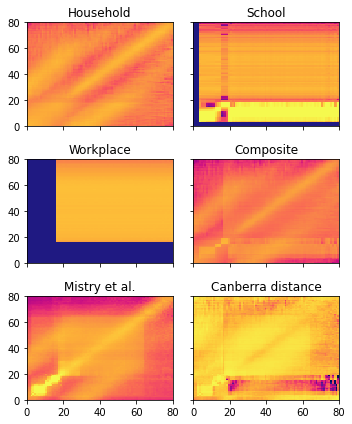

In [37]:
plot_linear_combination(households_cm,
                        schools_cm,
                        workplaces_cm,
                        mistry_matrix,
                        optimised_linear_coefficients,
                        vmins=[1e-6, 1e-7, 1e-8, 1e-5, 1e-4],
                        vmaxes=[1, 1e-1, 1, 1, 1])